## Import Packages

In [26]:
# !pip install scanpy
import scanpy as sc
# !pip install scvi
# import scvi
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Import Data

In [27]:
# Import Raw Data
adata = sc.read_h5ad('/home/glennrdx/Documents/Research_Project/published_reference_material/h5ad_files/4_GSE147319_adata_villus_raw.h5ad')
print(adata)

AnnData object with n_obs × n_vars = 9852 × 31125
    obs: 'diet', 'mt_fraction', 'n_counts', 'n_genes'
    uns: 'diet_colors'


## Data Cleaning
1. Removed Previous researchers work to start from scratch

In [28]:
# Specify the columns to remove
columns_to_remove = ['mt_fraction', 'n_counts', 'n_genes']  # Replace with actual column names

# Remove specified columns
adata.obs = adata.obs.drop(columns=columns_to_remove)
adata.obs.index.name = None

# Rename adata.obs['diet'] to 'Diet'
adata.obs.rename(columns={'diet': 'Diet'}, inplace=True)

# Correct the naming of the diets
adata.obs['Diet'] = adata.obs['Diet'].replace({'HFD': 'HFHSD'})

adata.obs

/tmp/ipykernel_22598/844612570.py:12: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['Diet'] = adata.obs['Diet'].replace({'HFD': 'HFHSD'})


Diet
AAACCTGAGAGCTTCT-1-CD      CD
AAACCTGAGATCCCAT-1-CD      CD
AAACCTGCAGACGTAG-1-CD      CD
AAACCTGCAGCTATTG-1-CD      CD
AAACCTGTCCTATTCA-1-CD      CD
...                       ...
TTTGTCACACGAGGTA-1-HFD  HFHSD
TTTGTCACAGGTGGAT-1-HFD  HFHSD
TTTGTCAGTGCCTTGG-1-HFD  HFHSD
TTTGTCAGTTTGTGTG-1-HFD  HFHSD
TTTGTCATCGAATGGG-1-HFD  HFHSD

[9852 rows x 1 columns]

## Quality Control  
**Description:**  
The scanpy function calculate_qc_metrics() calculates common quality control (QC) metrics. Mitochondrial, ribosomal and hemoglobin genes are defined as shown below.

In [29]:
# mitochondrial genes, "MT-" for human, "mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^Hb[^(pe)]")

In [30]:
print('Number of mitochondrial genes:', adata.var['mt'].sum())
print('Number of ribosomal genes:', adata.var['ribo'].sum())
print('Number of hemoglobin genes:', adata.var['hb'].sum())

Number of mitochondrial genes: 13
Number of ribosomal genes: 104
Number of hemoglobin genes: 11


In [31]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

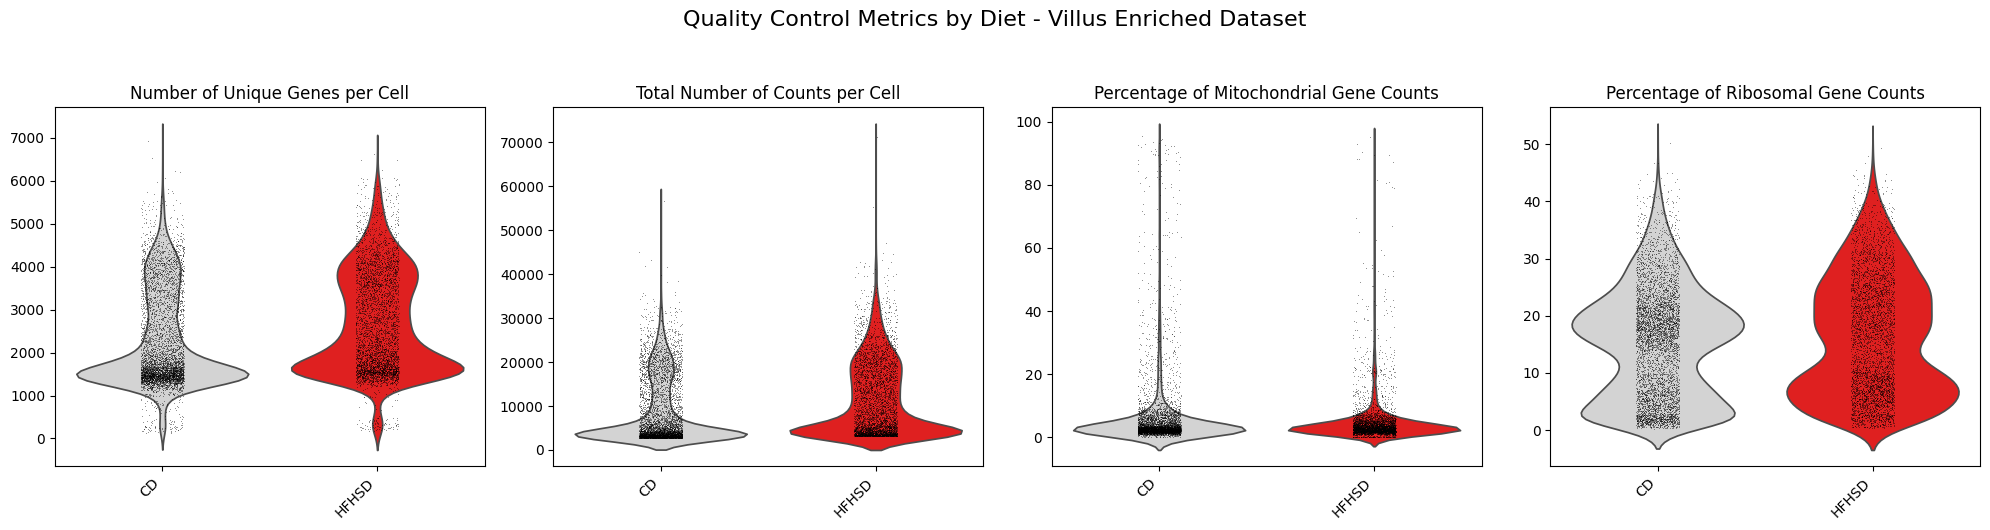

In [32]:
# Plotting violin plots with overlaid scatter plots in one row, grouped by diet
labels = ['Number of Unique Genes per Cell', 'Total Number of Counts per Cell', 'Percentage of Mitochondrial Gene Counts', 'Percentage of Ribosomal Gene Counts']
keys = ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Add main title for the whole graph
fig.suptitle('Quality Control Metrics by Diet - Villus Enriched Dataset', fontsize=16, y=1.05)

# Define color palette
color_palette = {'CD': 'lightgrey', 'HFHSD': 'red'}

for i, (label, key) in enumerate(zip(labels, keys)):
    ax = axes[i]
    
    # Create violin plot, grouped by diet
    sns.violinplot(data=adata.obs, x='Diet', y=key, hue='Diet', ax=ax, inner=None, palette=color_palette, legend=False)
    
    # Overlay scatter plot, grouped by diet
    sns.stripplot(data=adata.obs, x='Diet', y=key, ax=ax, size=0.4, jitter=True, dodge=False, legend=False, color='black')
    
    # Customize the plot
    ax.set_title(label)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    
    # Increase the number of y-axis ticks for the second plot (Total Number of Counts per Cell)
    if i == 1:
        ax.yaxis.set_major_locator(plt.MaxNLocator(10))

    # Rotate x-axis labels for better readability
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

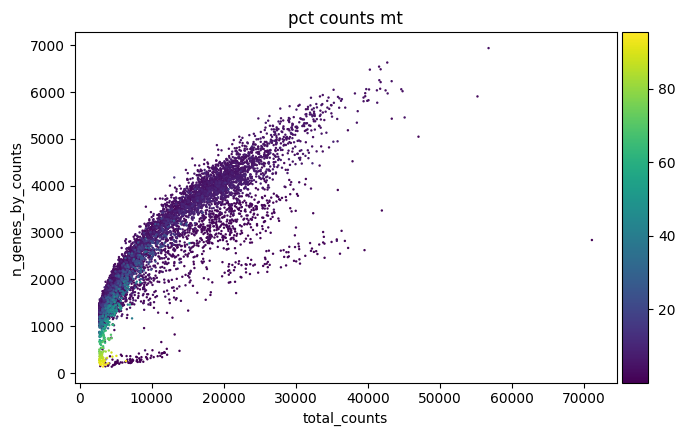

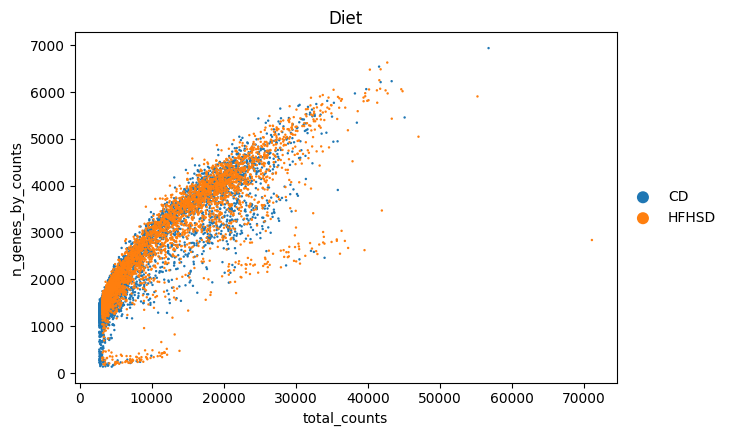

In [33]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color='pct_counts_mt')
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color='Diet')

## Gene and Cell filtering
1. Remove genes found in less than 10 cells.  
2. Remove cells with less than 200 genes by counts.
3. Remove cells with less than 500 total counts.

In [34]:
# 1. Remove genes found in less than 10 cells.
print('Number of genes:', len(adata.var))
print('Removing genes in less than 10 cells... ⌛')
sc.pp.filter_genes(adata, min_cells = 5)
print('Number of genes:', len(adata.var))

Number of genes: 31125
Removing genes in less than 10 cells... ⌛
Number of genes: 17874


In [35]:
# 2. Remove cells with less than 200 genes by counts.
print('Number of cells:', len(adata.obs))
print('Removing cells with less than 200 genes by counts... ⌛')
sc.pp.filter_cells(adata, min_genes = 200)
print('Number of cells:', len(adata.obs))

Number of cells: 9852
Removing cells with less than 200 genes by counts... ⌛
Number of cells: 9832


In [36]:
# 2. Remove cells with less than 500 total counts.
print('Number of cells:', len(adata.obs))
print('Removing cells with less than 500 total counts... ⌛')
sc.pp.filter_cells(adata, min_counts = 500)
print('Number of cells:', len(adata.obs))

Number of cells: 9832
Removing cells with less than 500 total counts... ⌛
Number of cells: 9832


In [37]:
mask = adata.obs['pct_counts_mt'] < 10

# Apply the mask to filter the AnnData object
adata = adata[mask].copy()

print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

Number of cells after MT filter: 8984


## Doublet Removal with scrublet
**Description:**  
Identifying doublets is crucial as they can lead to misclassifications or distortions in downstream analysis steps. Scrublet predicts cell doublets using a nearest-neighbor classifier of observed transcriptomes and simulated doublets.

In [38]:
print('Predicting doublets... ⌛')
sc.pp.scrublet(adata, threshold = 0.3)

Predicting doublets... ⌛


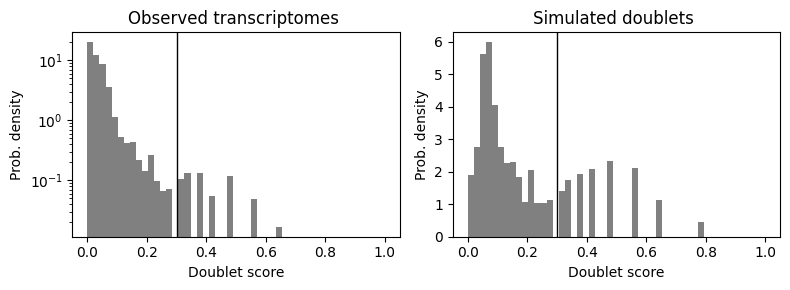

In [39]:
# Doublet score distribution by sample
sc.pl.scrublet_score_distribution(adata)

In [40]:
print('Number of predicted doublets:', adata.obs['predicted_doublet'].sum())

Number of predicted doublets: 111


In [41]:
print('Number of cells:', len(adata.obs))
print('Removing Doublets...')
adata = adata[adata.obs['predicted_doublet'] == False].copy()
print('Number of cells:', len(adata.obs))

Number of cells: 8984
Removing Doublets...
Number of cells: 8873


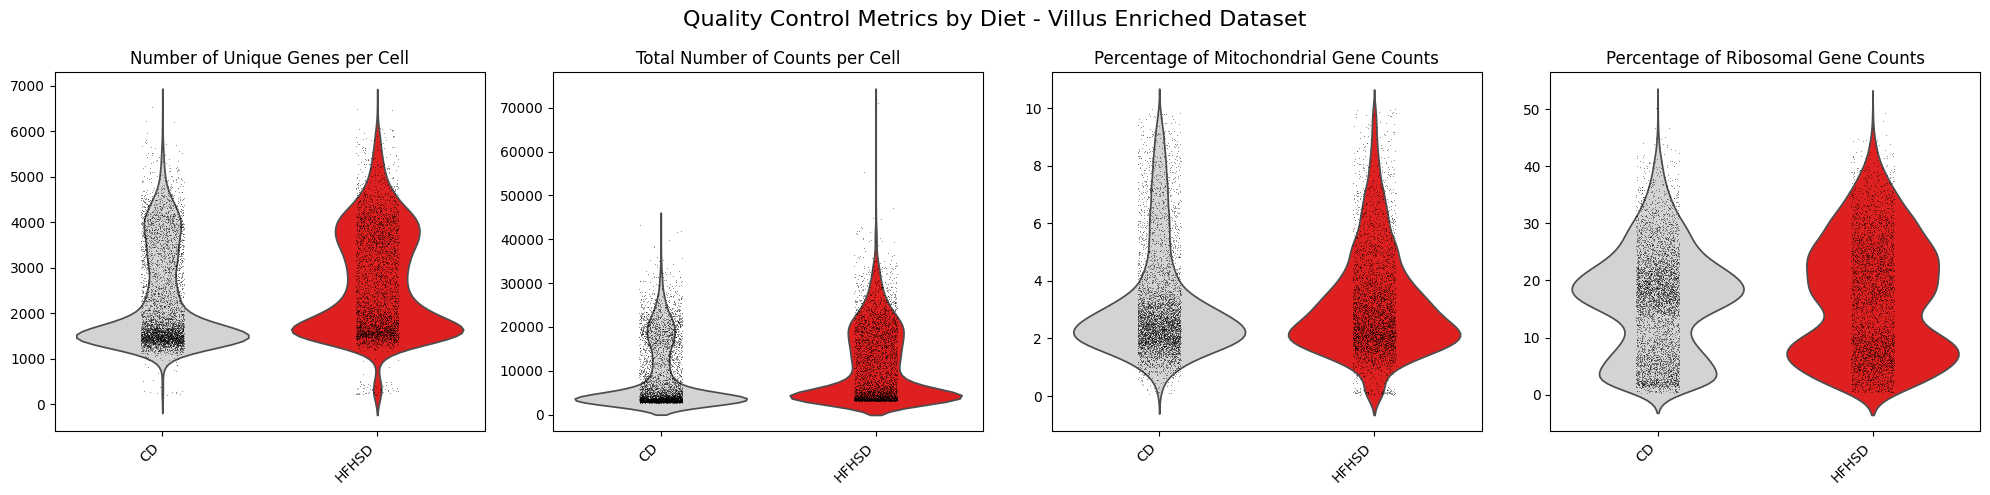

In [46]:
# Plotting violin plots with overlaid scatter plots in one row, grouped by diet
labels = ['Number of Unique Genes per Cell', 'Total Number of Counts per Cell', 'Percentage of Mitochondrial Gene Counts', 'Percentage of Ribosomal Gene Counts']
keys = ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Add main title for the whole graph
fig.suptitle('Quality Control Metrics by Diet - Villus Enriched Dataset', fontsize=16)

# Define color palette
color_palette = {'CD': 'lightgrey', 'HFHSD': 'red'}

for i, (label, key) in enumerate(zip(labels, keys)):
    ax = axes[i]
    
    # Create violin plot, grouped by diet
    sns.violinplot(data=adata.obs, x='Diet', y=key, hue='Diet', ax=ax, inner=None, palette=color_palette, legend=False)
    
    # Overlay scatter plot, grouped by diet
    sns.stripplot(data=adata.obs, x='Diet', y=key, ax=ax, size=0.4, jitter=True, dodge=False, legend=False, color='black')
    
    # Customize the plot
    ax.set_title(label)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    
    # Increase the number of y-axis ticks for the second plot (Total Number of Counts per Cell)
    if i == 1:
        ax.yaxis.set_major_locator(plt.MaxNLocator(10))

    # Rotate x-axis labels for better readability
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Normalisation  
**Description:**  
A common approach is count depth scaling with subsequent log plus one (log1p) transformation. Count depth scaling normalizes the data to a “size factor” such as the median count depth in the dataset, ten thousand (CP10k) or one million (CPM, counts per million). The size factor for count depth scaling can be controlled via target_sum in pp.normalize_total. We are applying median count depth normalization with log1p transformation (AKA log1PF).

In [17]:
# Save raw counts for batch effect correction later
adata.layers["counts"] = adata.X.copy()

In [18]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
adata.raw = adata

## Feature selection  
Keep only the top variable genes.  

In [19]:
# n_top_genes = 2000

# # Keep the top n variable genes
# print('Number of genes:', len(adata.var))

# # # Method 1
# # print(f'Selecting top {n_top_genes} variable genes... ⌛')
# # sc.pp.highly_variable_genes(adata, 
# #                             n_top_genes = n_top_genes, 
# #                             batch_key = 'Sample', 
# #                             subset = True, 
# #                             flavor = 'seurat_v3')

# # Method 2
# sc.pp.highly_variable_genes(adata, min_mean=0.0125, min_disp=0.5)
# adata = adata[:, adata.var['highly_variable']]

# print('Number of genes:', len(adata.var))

In [20]:
# sc.pl.highly_variable_genes(adata)

## Dimensionality Reduction  
**Description:**  
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [21]:
sc.tl.pca(adata, random_state = 3)

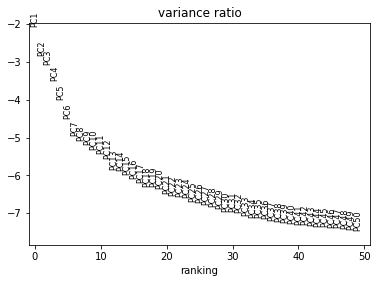

In [22]:
# Inspect contribution of each individual PC to the total variance in the data.
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

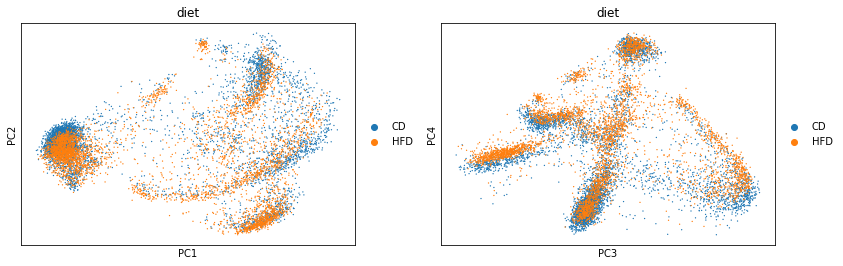

In [23]:
sc.pl.pca(
    adata,
    color=["diet"],
    dimensions=[(0, 1), (2, 3)],
    ncols=2,
    size=7,
)

## Nearest neighbor graph constuction and UMAP (First attempt)

In [24]:
sc.pp.neighbors(adata, random_state = 3)
sc.tl.umap(adata, random_state = 3)
sc.tl.leiden(adata, resolution = 0.1, random_state = 3)

2024-07-23 19:47:21.444166: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_7304/2564921398.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.1, random_state = 3)


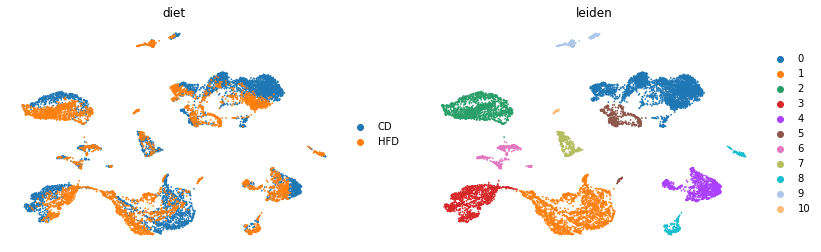

In [25]:
sc.pl.umap(
    adata,
    color=["diet", "leiden"],
    ncols=2,
    frameon=False)

# Exclude Immune Cells And Fibroblasts

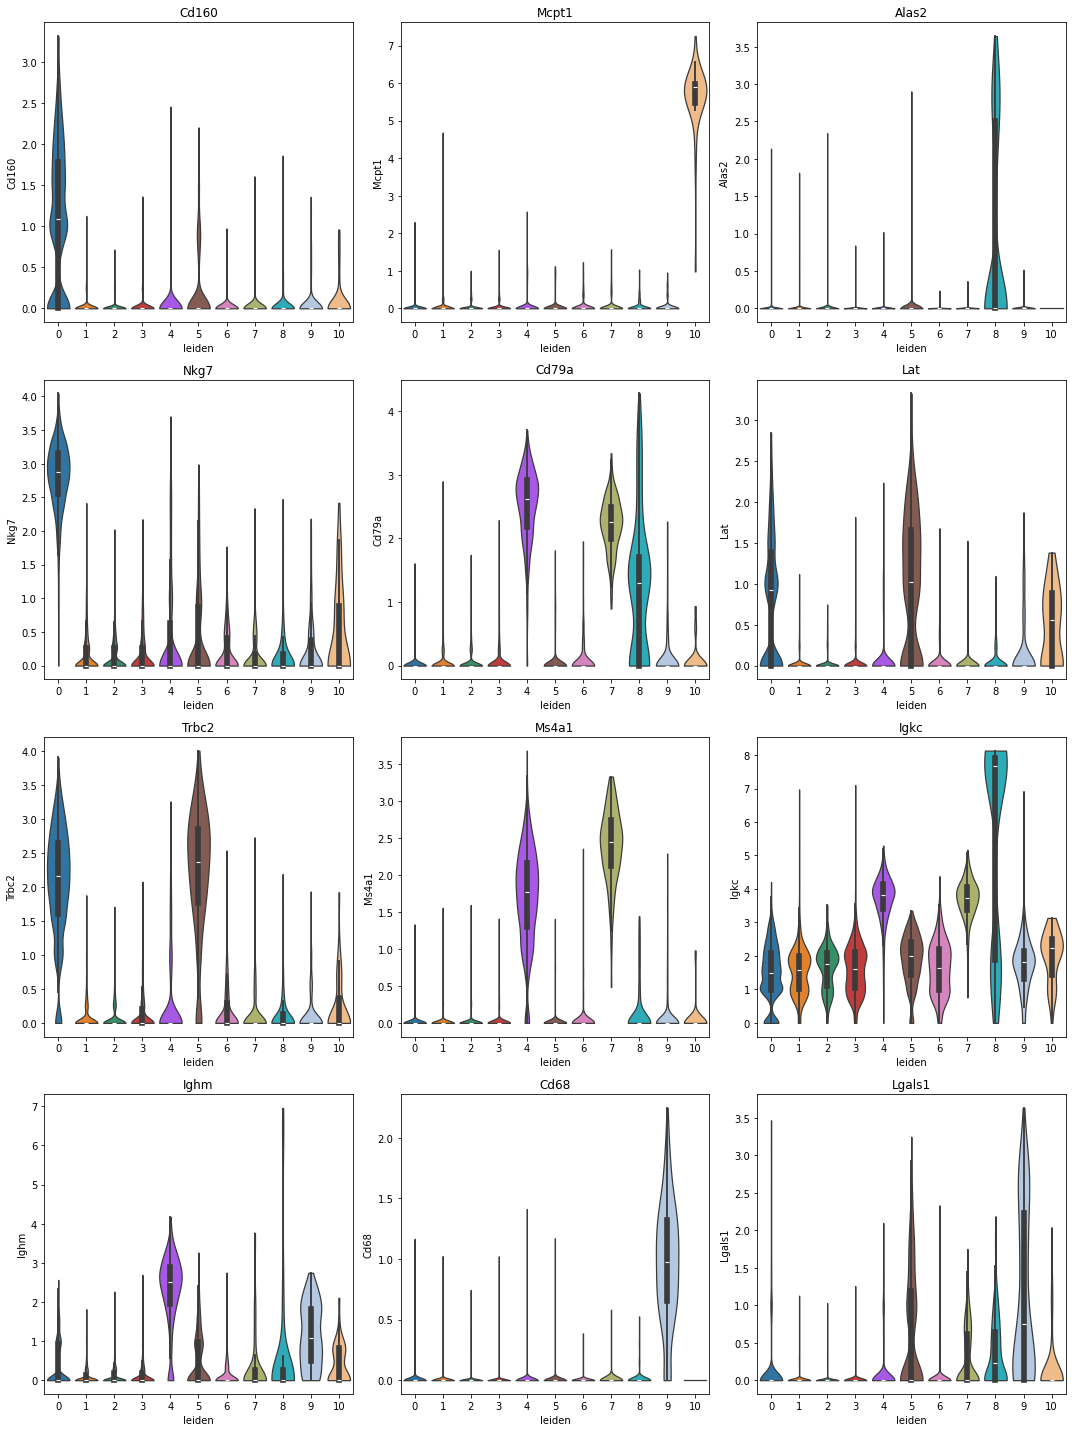

In [26]:
genes = ['Cd160', 'Mcpt1', 'Alas2', 'Nkg7', 'Cd79a', 'Lat', 'Trbc2', 'Ms4a1', 'Igkc', 'Ighm', 'Cd68', 'Lgals1']
groupby = 'leiden'
n_cols = 3
n_rows = (len(genes) + n_cols - 1) // n_cols  # Calculate the number of rows needed

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
axs = axs.flatten()

for i, gene in enumerate(genes):
    sc.pl.violin(adata, keys=[gene], groupby=groupby, inner="box", stripplot=False, ax=axs[i], show=False)
    axs[i].set_title(gene)

# Hide any unused subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

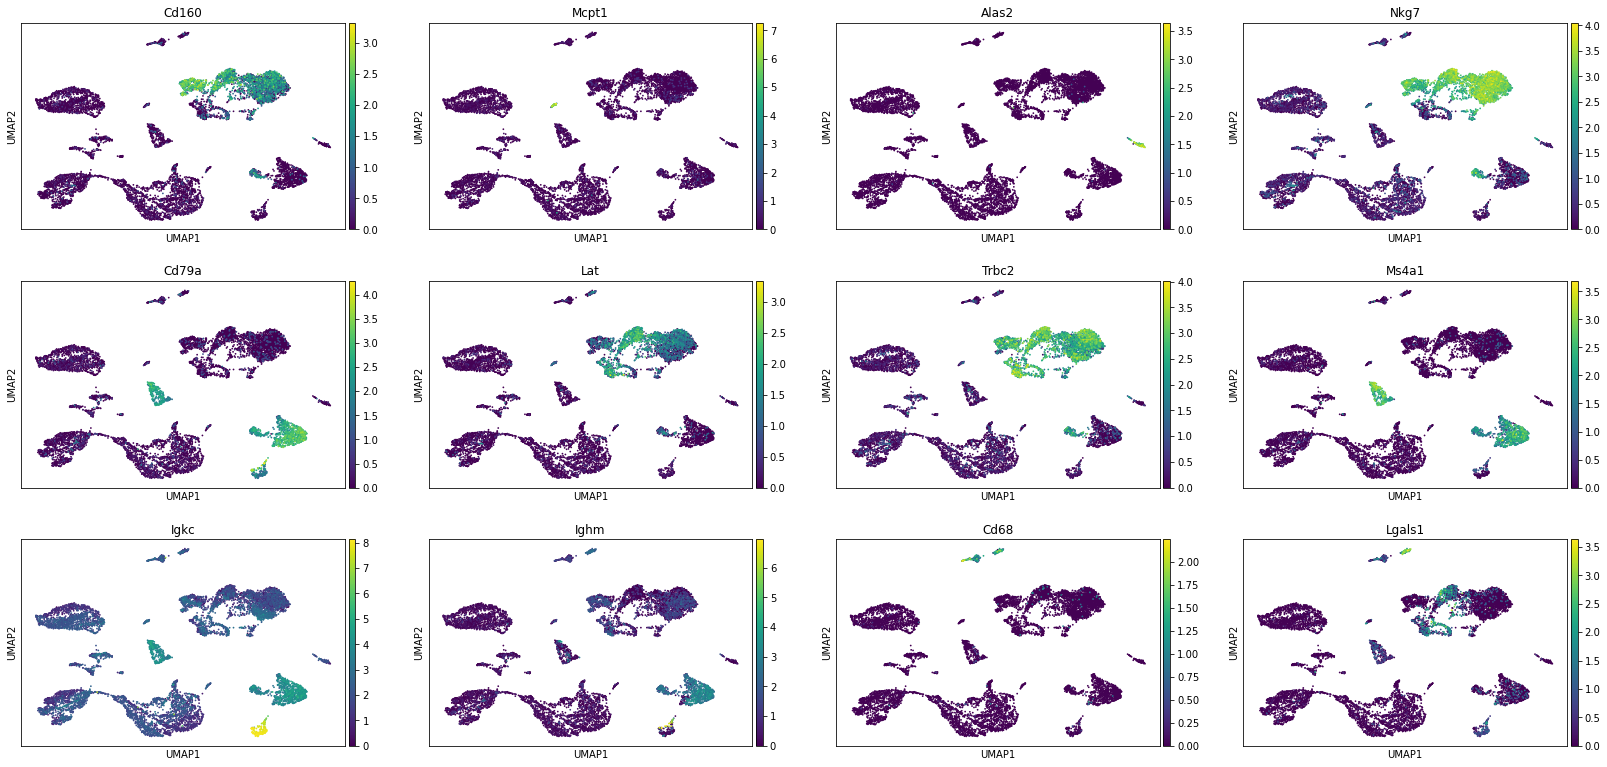

In [27]:
sc.pl.umap(adata, color=['Cd160', 'Mcpt1', 'Alas2', 'Nkg7', 'Cd79a', 'Lat', 'Trbc2', 'Ms4a1', 'Igkc', 'Ighm', 'Cd68', 'Lgals1'])

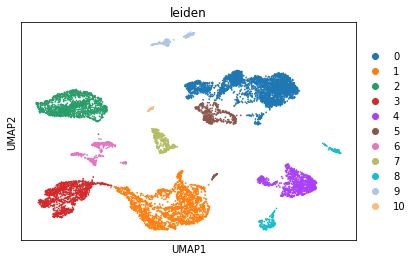

In [28]:
sc.pl.umap(adata, color=['leiden'])

In [29]:
adata_immune_fibro = adata[adata.obs.leiden.isin(['0', '4', '5', '7', '8', '9', '10'])].copy()
adata = adata[adata.obs.leiden.isin(['1', '2', '3', '6'])].copy()

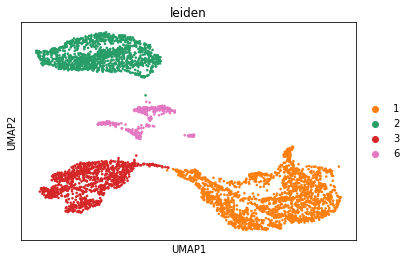

In [30]:
sc.pl.umap(adata, color=['leiden'])

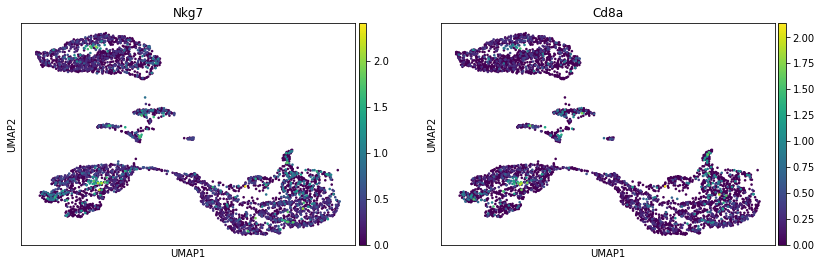

In [31]:
# Highlight immune cells (?and doublet clusters)
sc.pl.umap(adata, color=['Nkg7', 'Cd8a'])

We can see that there are some immune cells being highlighted in cluster 3. We will need to filter these out.

In [32]:
# Recluster cluster 3 and add to a newly created annotation column in adata.obs 'refined_1'
sc.tl.louvain(adata, restrict_to=('leiden',['3']), key_added='leiden_1', resolution=0.65, random_state = 3)

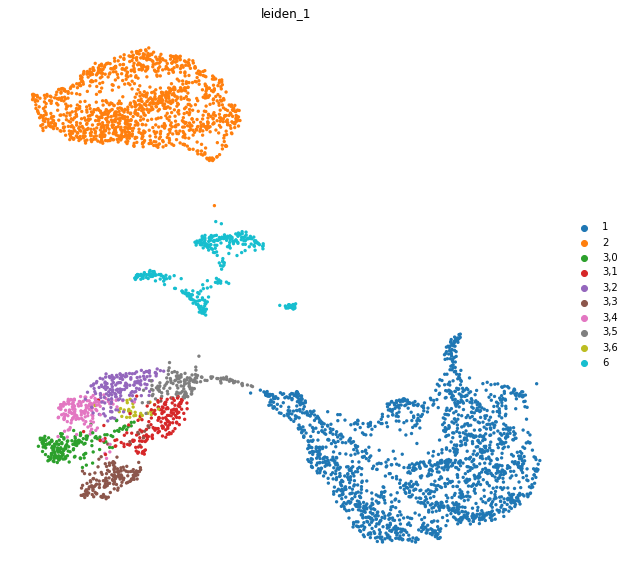

In [33]:
# Plot the UMAP
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata,
    color=["leiden_1"],
    frameon=False,
    size=45,
    ax=ax
)

# Show the plot
plt.show()

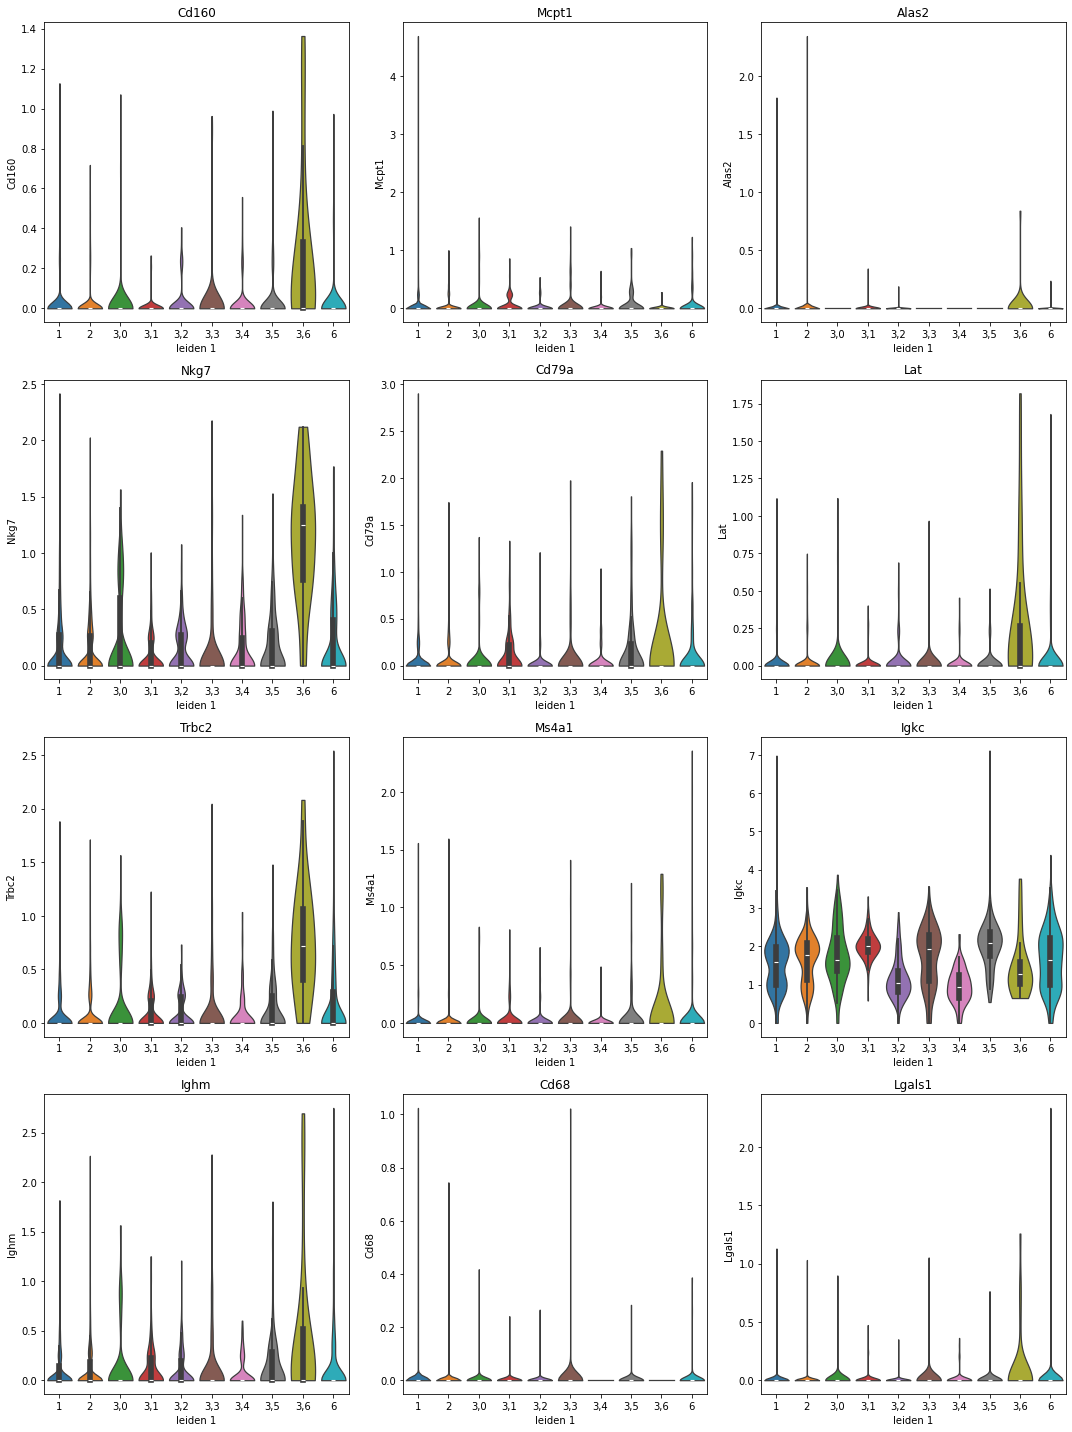

In [34]:
genes = ['Cd160', 'Mcpt1', 'Alas2', 'Nkg7', 'Cd79a', 'Lat', 'Trbc2', 'Ms4a1', 'Igkc', 'Ighm', 'Cd68', 'Lgals1']
groupby = 'leiden_1'
n_cols = 3
n_rows = (len(genes) + n_cols - 1) // n_cols  # Calculate the number of rows needed

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
axs = axs.flatten()

for i, gene in enumerate(genes):
    sc.pl.violin(adata, keys=[gene], groupby=groupby, inner="box", stripplot=False, ax=axs[i], show=False)
    axs[i].set_title(gene)

# Hide any unused subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [35]:
# Remove cells highly expressing 'Nkg7', 'Cd8a'
adata = adata[~adata.obs['leiden_1'].isin(['3,6'])].copy()

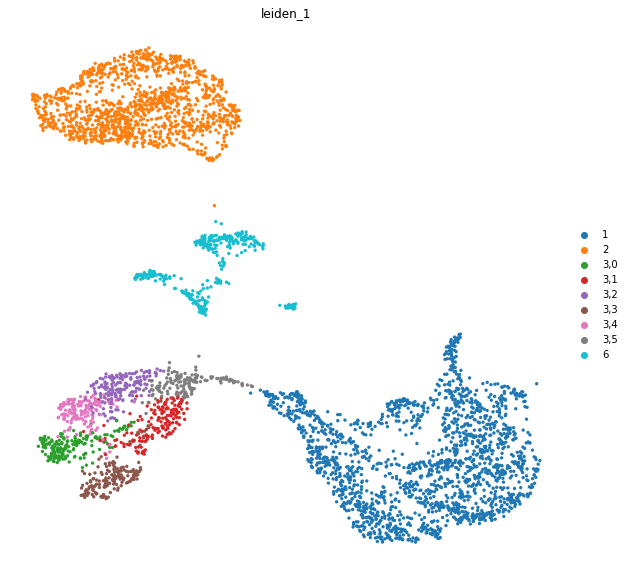

In [36]:
# Plot the UMAP
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata,
    color=["leiden_1"],
    frameon=False,
    size=45,
    ax=ax
)

# Show the plot
plt.show()

In [37]:
# adata = sc.read_h5ad('/home/glennrd/Documents/Research_Project/RNA-seq_Analysis/data/crypt_processed.h5ad') # unannotated
adata_published = sc.read_h5ad('/home/glennrd/Documents/Research_Project/RNA-seq_Analysis/published_reference_material/h5ad_files/3_GSE147319_adata_villus_processed.h5ad') #annotations stored in obs. Column name = 'groups _named_prog4'

# Rownames in the obs object are the UMI names in both anndata objects

# Extract the 'obs' data frames
obs_unannotated = adata.obs
obs_annotated = adata_published.obs[['louvain_anno']]

# Merge the data frames on the index (UMIs), keeping only common UMIs
merged_obs = obs_unannotated.merge(obs_annotated, left_index=True, right_index=True, how='left')

# Rename the column in the merged DataFrame
merged_obs.rename(columns={'louvain_anno': 'published_annotations'}, inplace=True)

# Update the 'obs' attribute of the unannotated AnnData object
adata.obs = merged_obs

/home/glennrd/.local/lib/python3.10/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/glennrd/.local/lib/python3.10/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


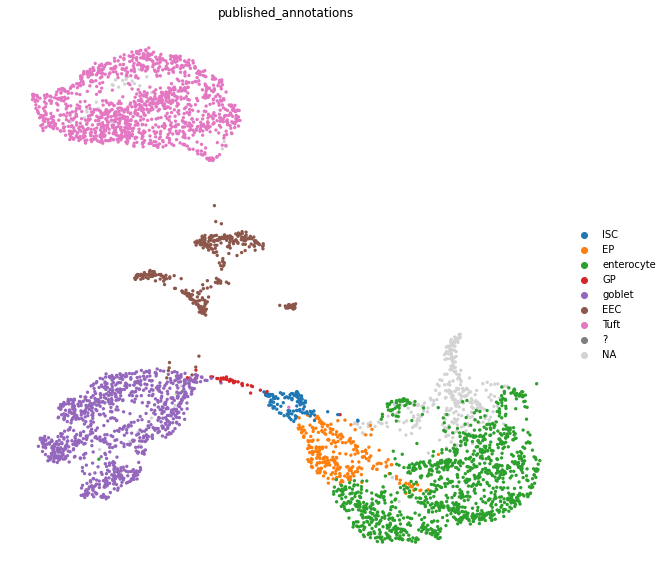

In [38]:
# Plot the UMAP
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata,
    color=["published_annotations"],
    frameon=False,
    size=45,
    ax=ax
)

# Show the plot
plt.show()

## Recluster

In [39]:
sc.pp.neighbors(adata, random_state = 3)
sc.tl.umap(adata, random_state = 3)
sc.tl.leiden(adata, resolution = 0.2, random_state = 3)

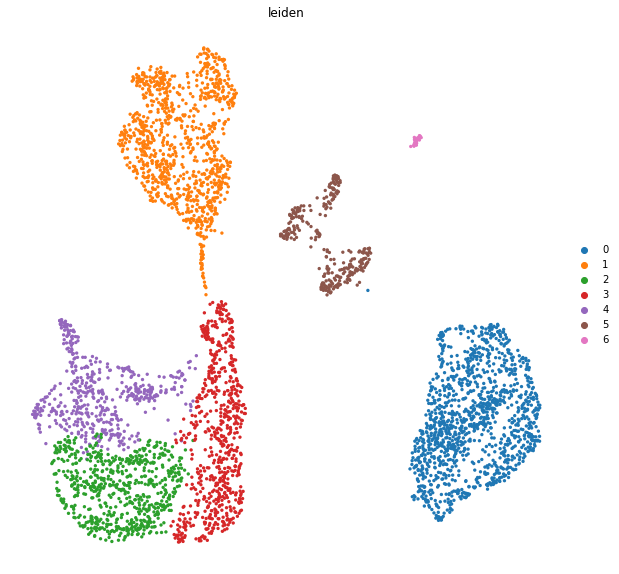

In [40]:
# Plot the UMAP
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon=False,
    size=45,
    ax=ax
)

# Show the plot
plt.show()

In [41]:
marker_dict = {'ISC': ['Lgr5', 'Olfm4', 'Axin2', 'Ascl2', 'Slc12a2'],
               'Enterocyte': ['Fabp1', 'Alpi', 'Apoa1', 'Apoa4', 'Lct'],
               'Goblet': ['Muc2', 'Tff3', 'Agr2', 'Spdef', 'Klf4', 'Tff3', 'Ccl9', 'Manf'],
               'Goblet progenitor': ['Spdef', 'Atoh1'],
               'Paneth': ['Lyz1', 'Mmp7', 'Defa17', 'Defa22', 'Ang4'],
               'EEC': ['Neurod1', 'Neurod2', 'Insm1', 'Chga', 'Chgb'],
               'EE progenitor': ['Sox4', 'Neurog3', 'Foxa2', 'Foxa3', 'Marcksl1'],
               'Tuft': ['Dclk1', 'Trpm5', 'Gfi1b', 'Il25'],
               'Lymphocyte': ['Coro1a', 'Cd52', 'Cd37']
               }

Violin plot: Clusters expressing ISC markers:


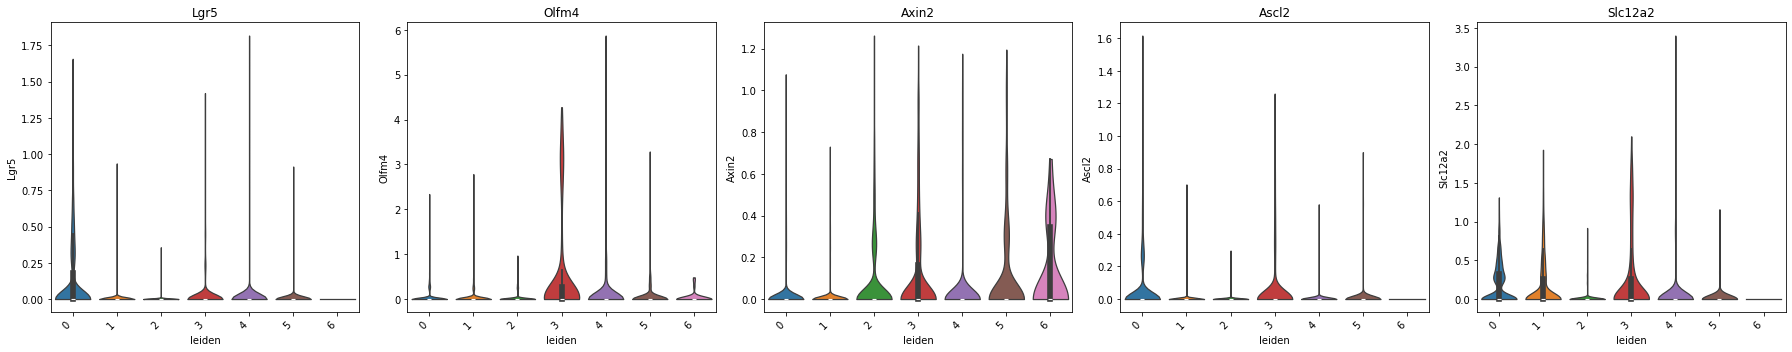

Violin plot: Clusters expressing Enterocyte markers:


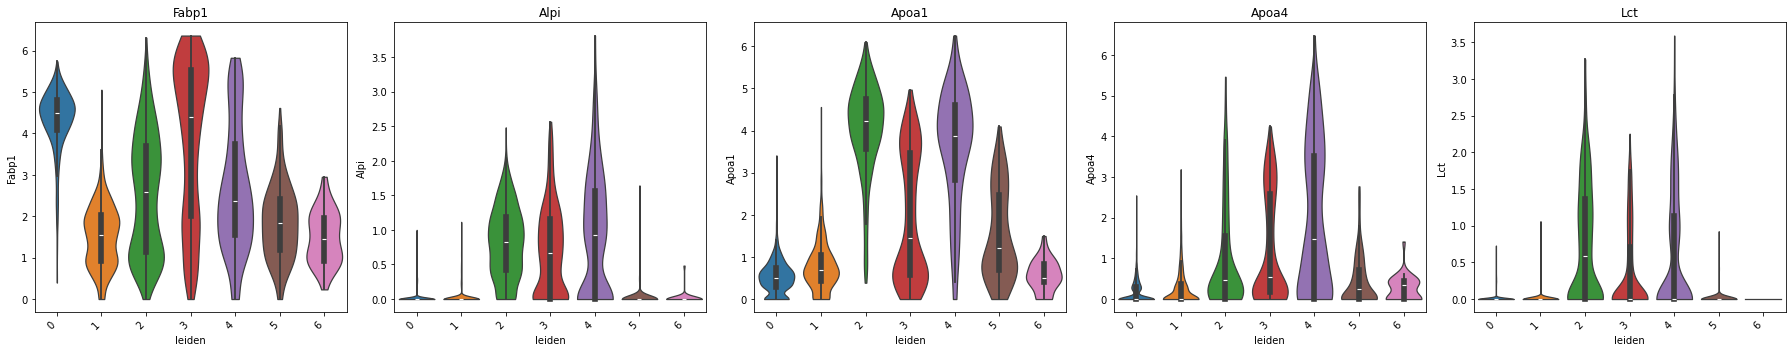

Violin plot: Clusters expressing Goblet markers:


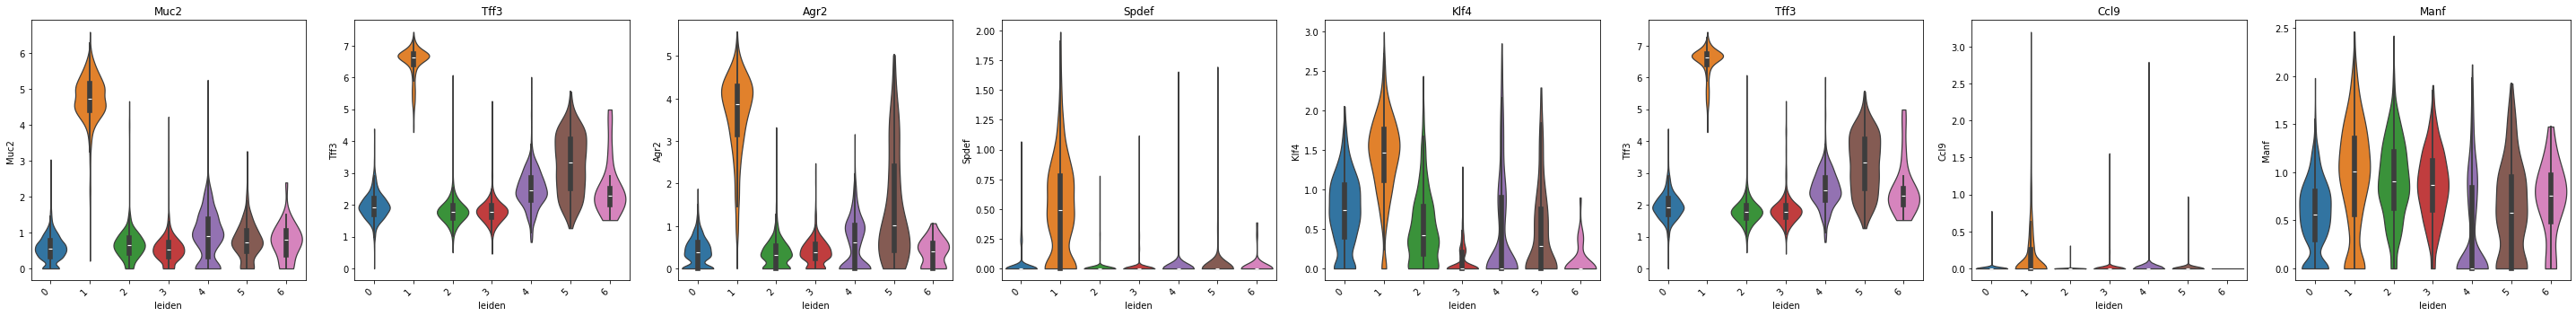

Violin plot: Clusters expressing Goblet progenitor markers:


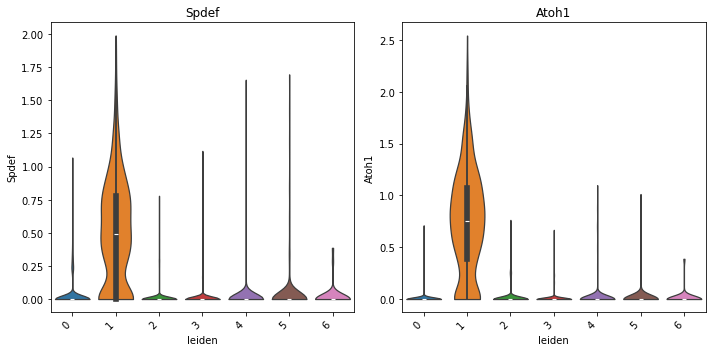

Violin plot: Clusters expressing Paneth markers:


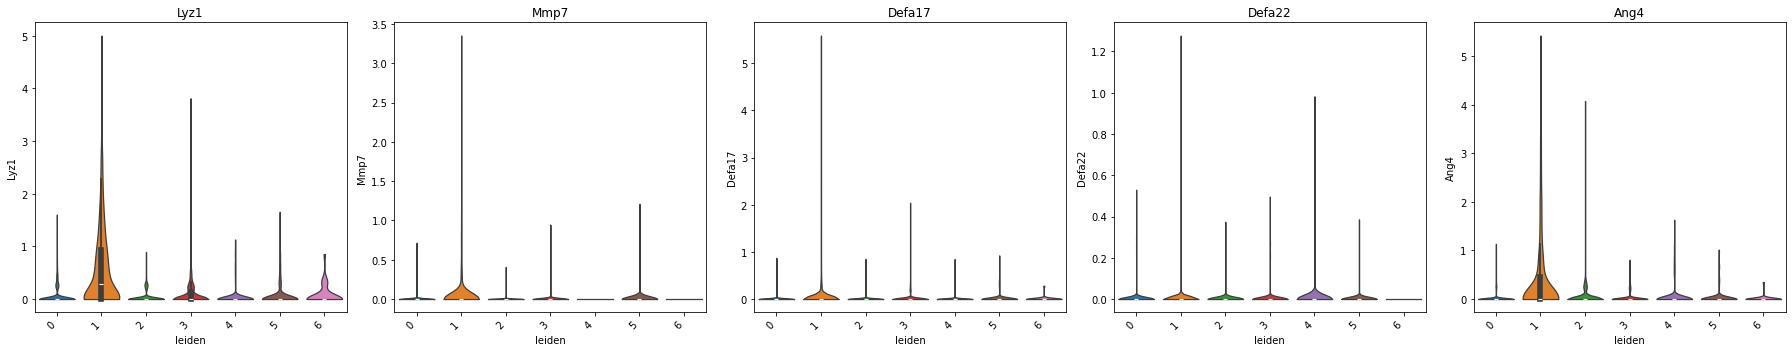

Violin plot: Clusters expressing EEC markers:


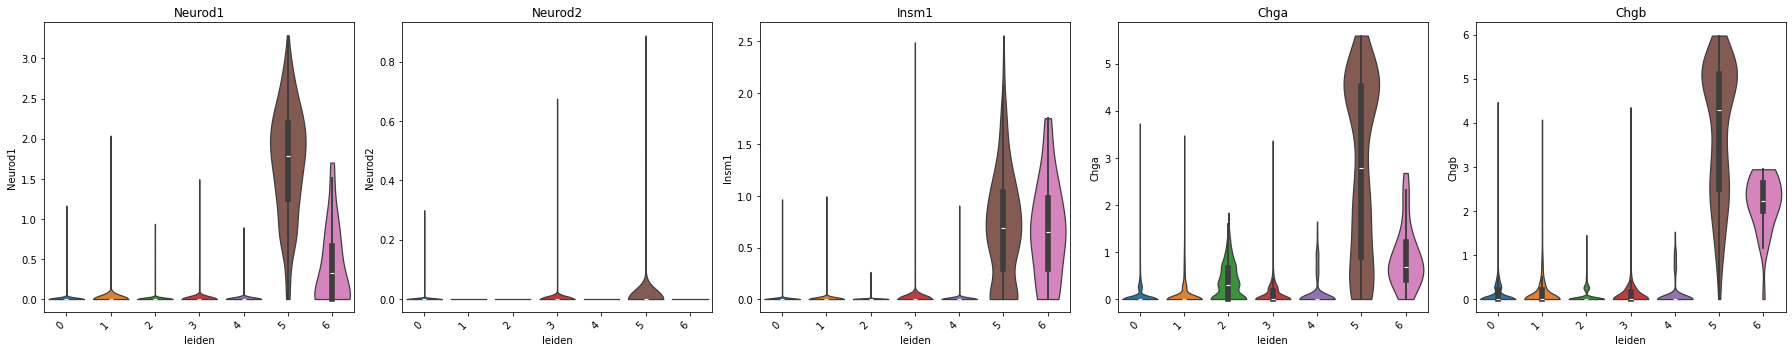

Violin plot: Clusters expressing EE progenitor markers:


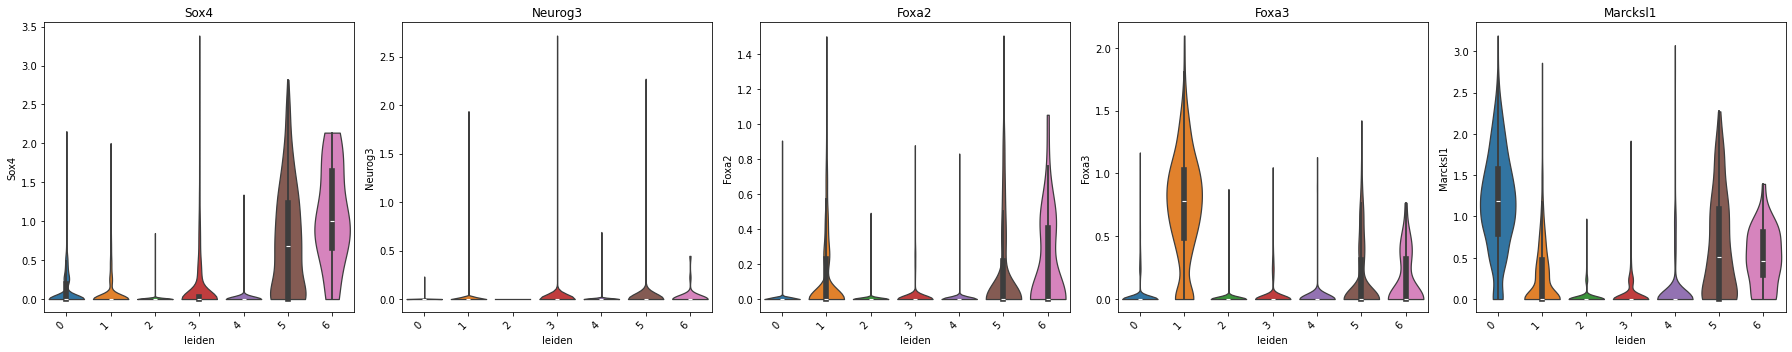

Violin plot: Clusters expressing Tuft markers:


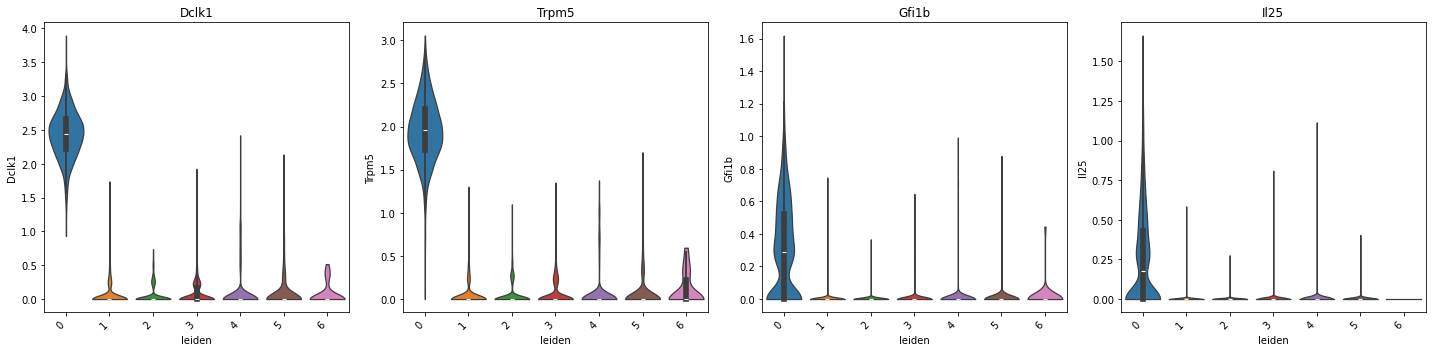

Violin plot: Clusters expressing Lymphocyte markers:


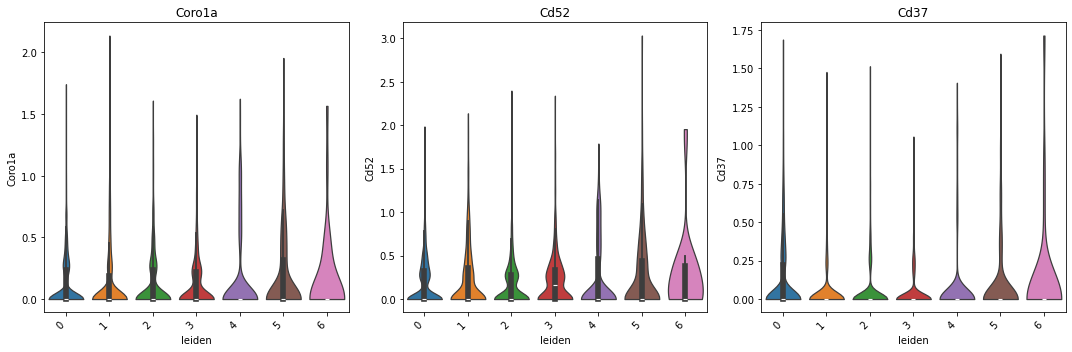

In [42]:
# Iterate over items in marker_dict
for marker, genes in marker_dict.items():
    print(f"Violin plot: Clusters expressing {marker} markers:")
    
    # Create a figure with subplots for this marker
    fig, axes = plt.subplots(1, len(genes), figsize=(len(genes) * 5, 5))
    
    # Iterate over genes associated with the current marker
    for i, gene in enumerate(genes):
        # Select the current axis
        ax = axes[i]
        
        # Plot the violin plot
        sc.pl.violin(adata,
                     keys=gene,
                     groupby='leiden',
                     inner="box",
                     stripplot=False,
                     show=False,
                     ax=ax)  # Pass the axis to plot on
        
        # Set plot title (optional)
        ax.set_title(gene)
        
        # Adjust alignment of x-axis labels
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_horizontalalignment('right')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Display the plots for the current marker
    plt.show()

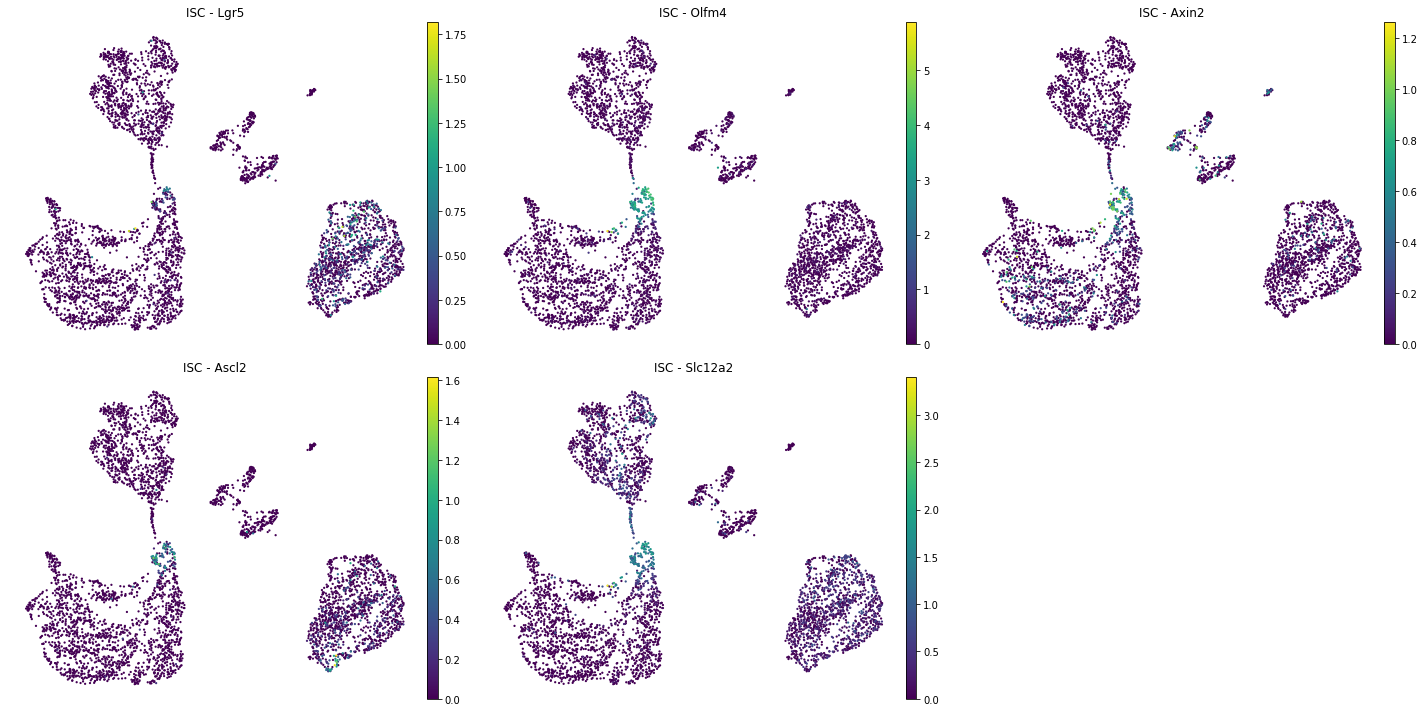

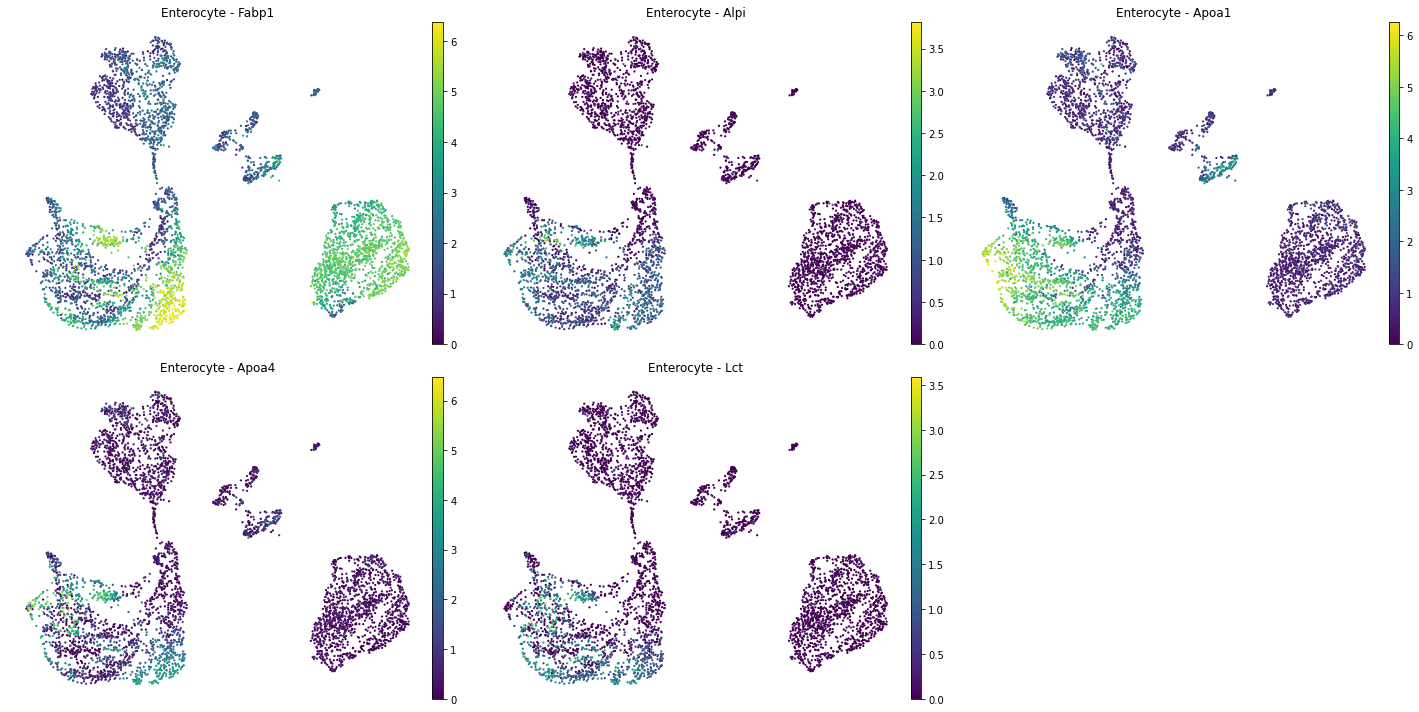

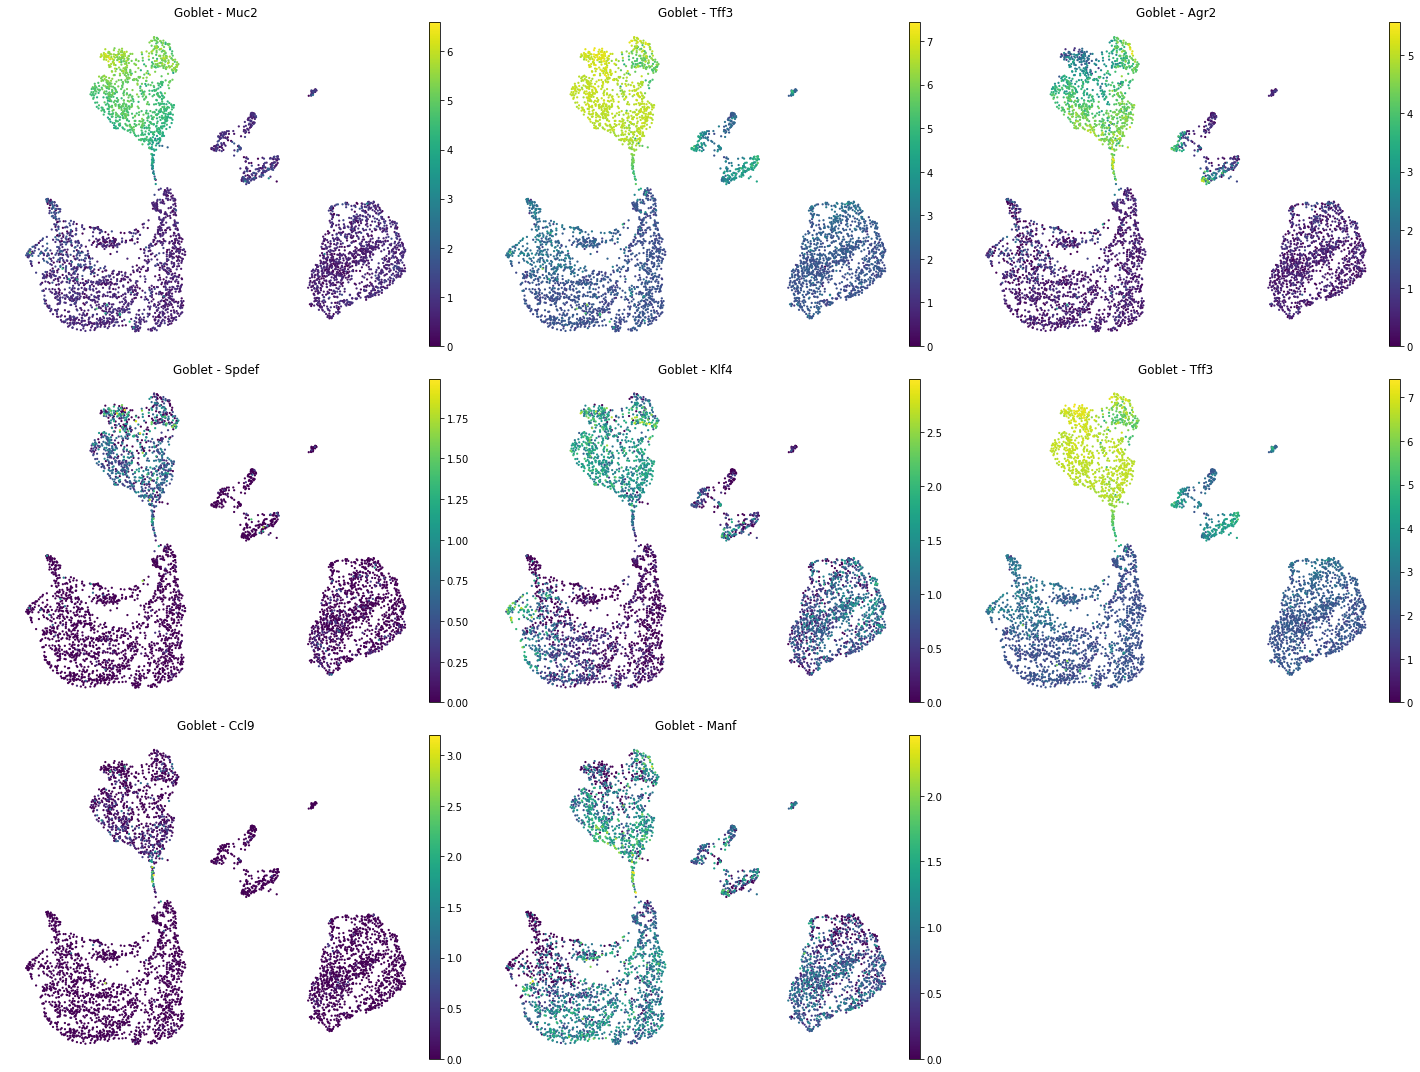

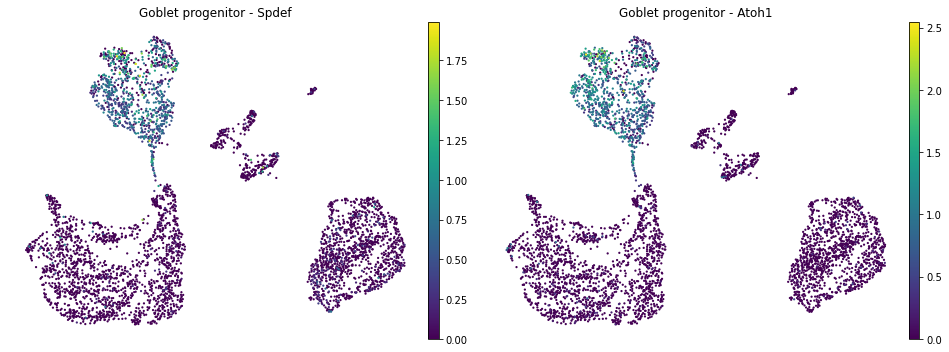

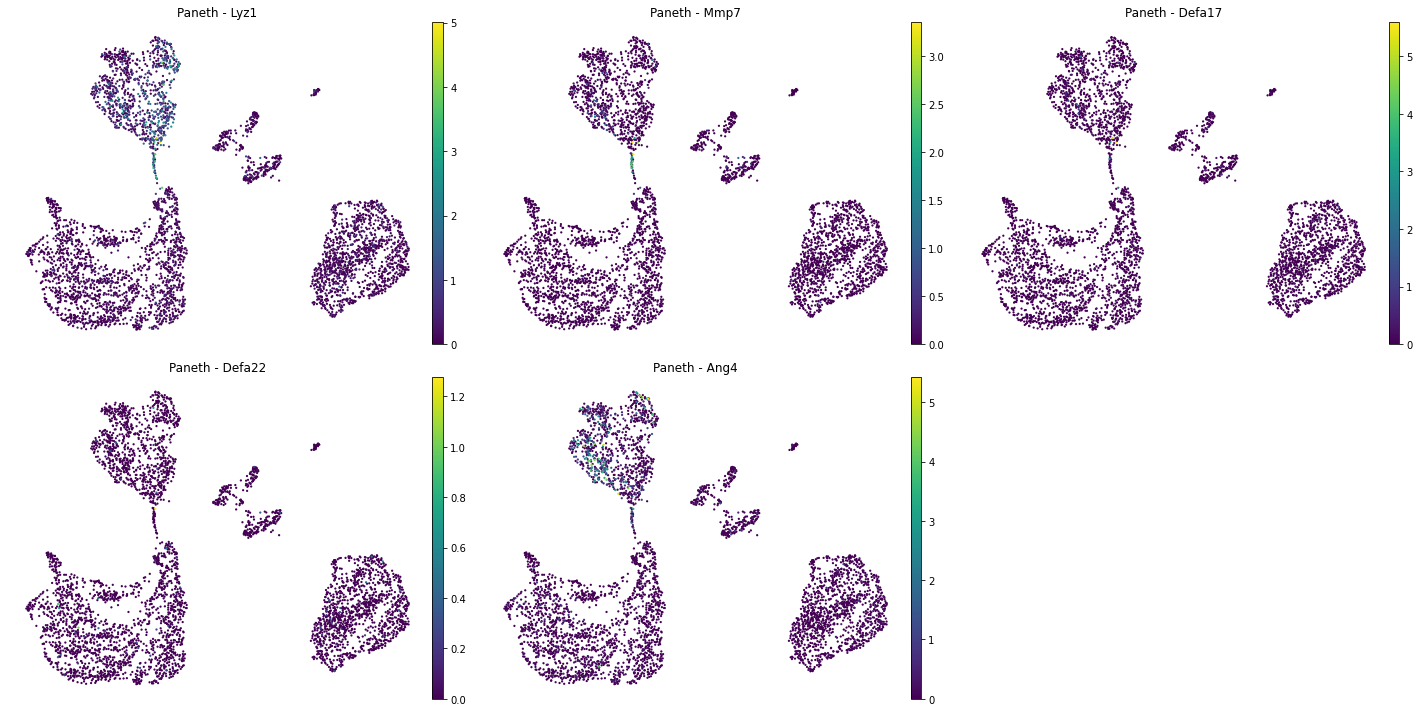

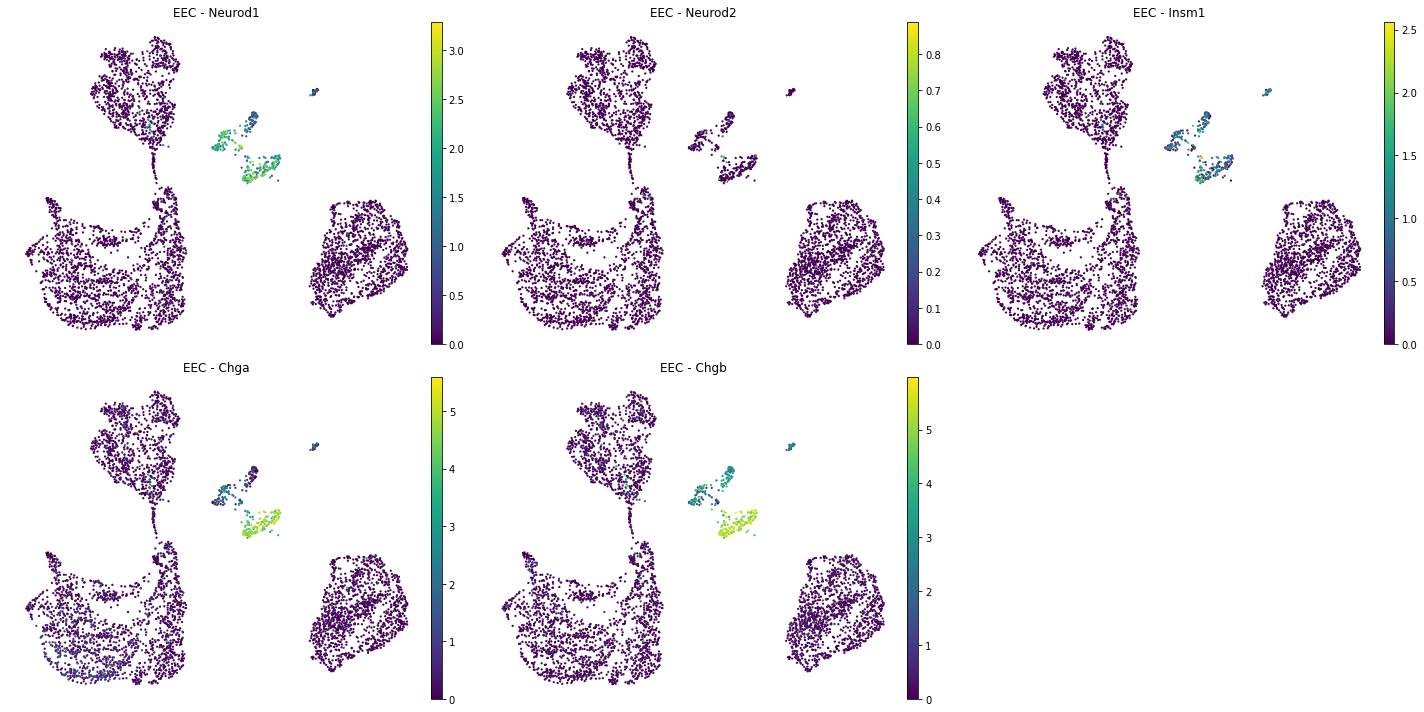

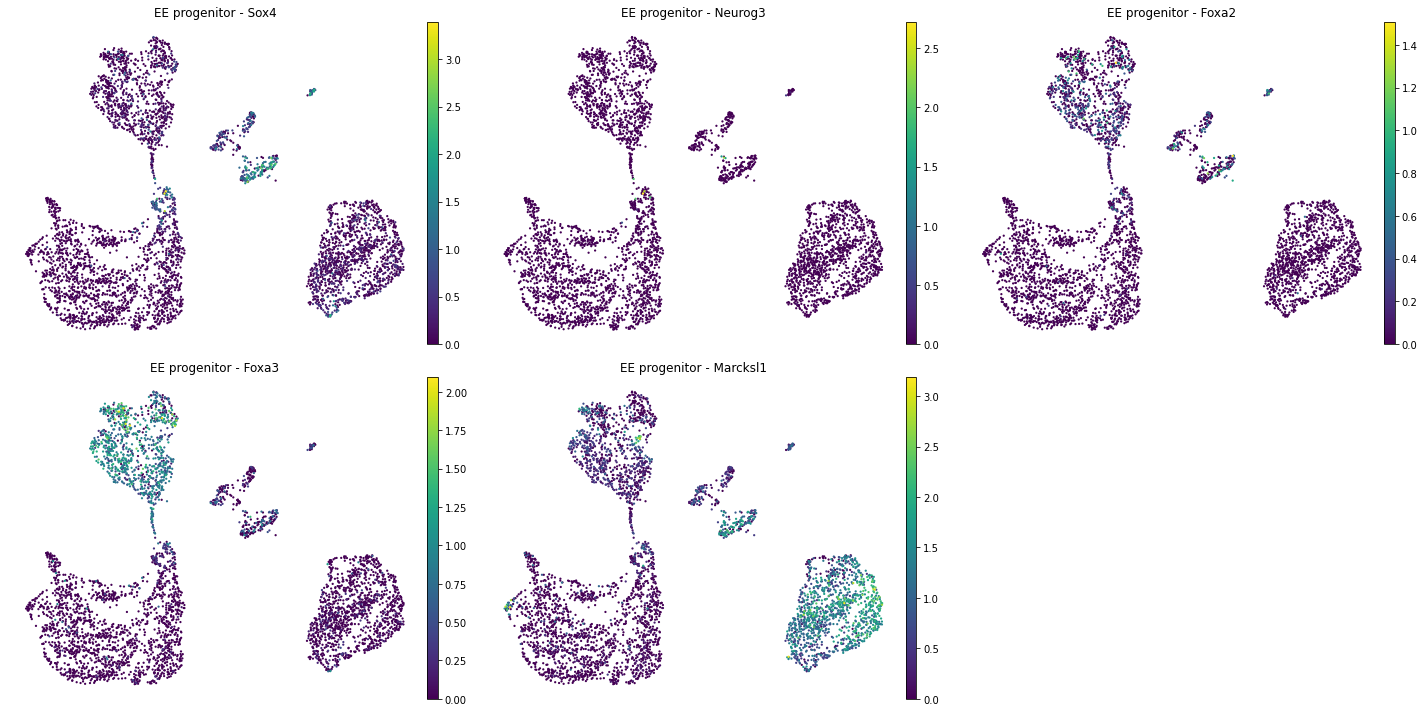

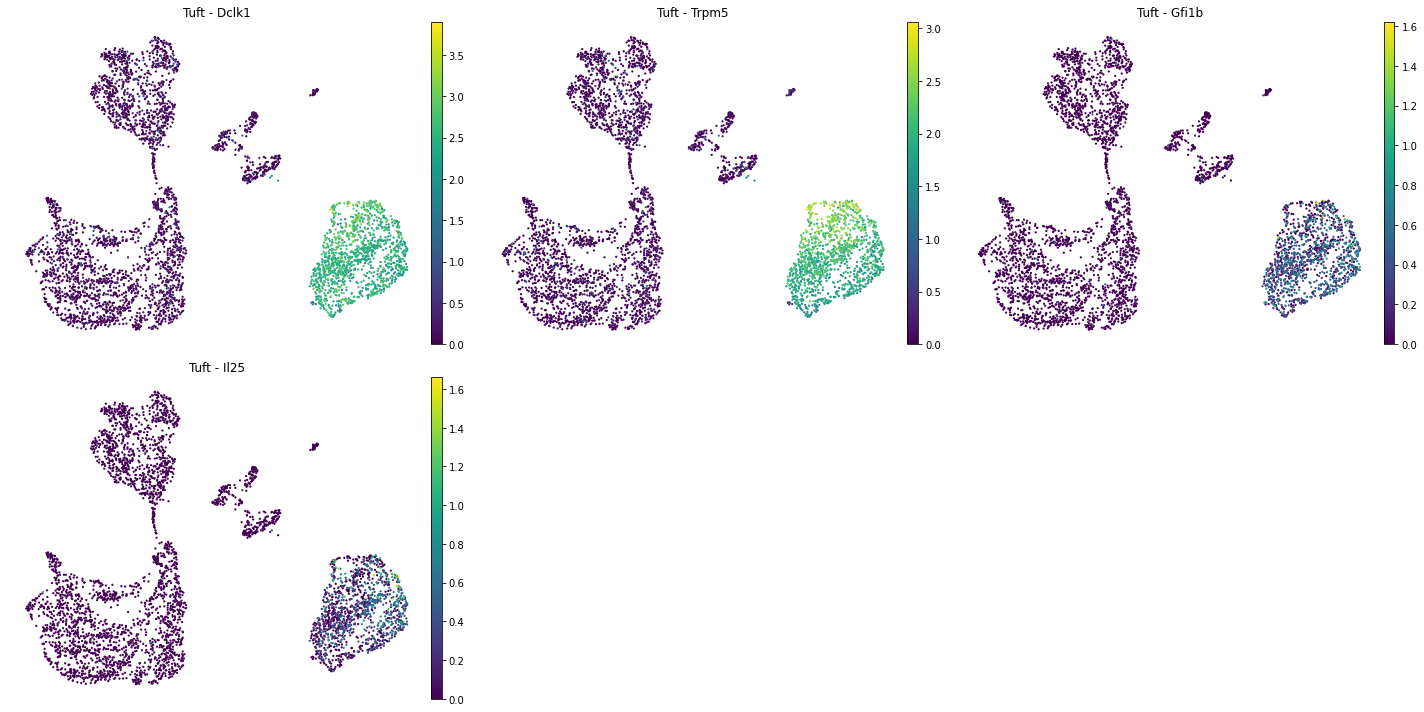

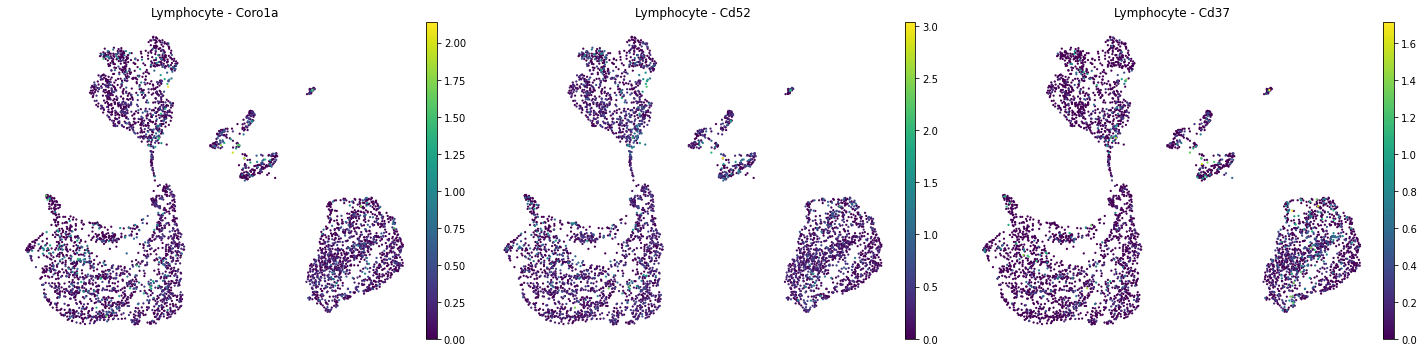

In [43]:
# Loop through each cell type and their markers
for cell_type, markers in marker_dict.items():
    # Calculate the number of rows needed
    n_markers = len(markers)
    n_cols = 3
    n_rows = (n_markers + n_cols - 1) // n_cols  # Ceiling division

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    for i, gene in enumerate(markers):
        sc.pl.umap(
            adata, 
            color=gene, 
            title=f'{cell_type} - {gene}',
            frameon=False, 
            ax=axes[i], 
            size = 20,
            color_map='viridis', 
            show=False
        )
        axes[i].set_facecolor('black')

    # Remove empty subplots
    for j in range(n_markers, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()

## Recluster cluster 3 to acquire ISC group

In [44]:
# Recluster cluster 3 and add to a newly created annotation column in adata.obs 'leiden_1'
sc.tl.louvain(adata, restrict_to=('leiden',['3']), key_added='leiden_2', resolution=0.4, random_state = 3)

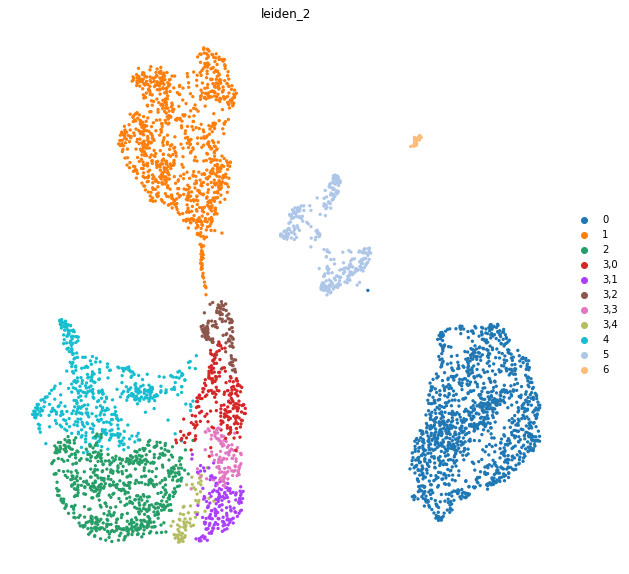

In [45]:
# Plot the UMAP
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata,
    color=["leiden_2"],
    frameon=False,
    size=45,
    ax=ax
)

# Show the plot
plt.show()

In [46]:
# Combine Enterocyte clusters into one cluster:

# Define the clusters to combine and the target label
clusters_to_combine = [
    '2',
    '4',
    '3,1',
    '3,3',
    '3,4'
    ]
target_label = '2'

# Extract the current cluster labels
cluster_labels = adata.obs['leiden_2']

# Update cluster labels for the specified clusters
adata.obs['leiden_2'] = cluster_labels.apply(lambda x: target_label if x in clusters_to_combine else x)

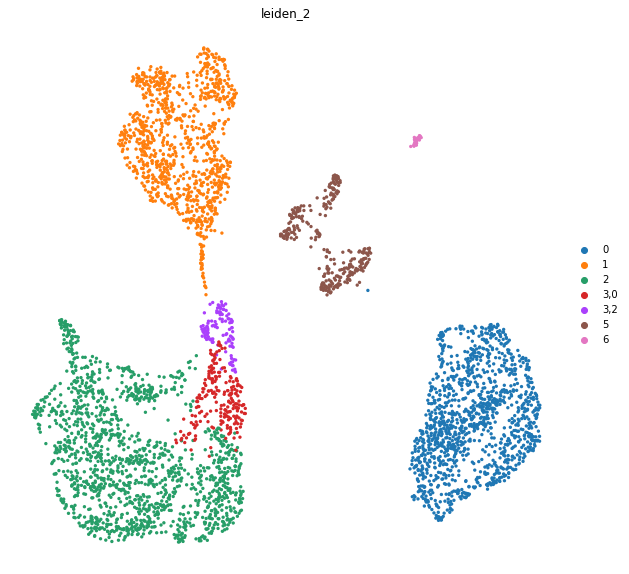

In [47]:
# Plot the UMAP
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata,
    color=["leiden_2"],
    frameon=False,
    size=45,
    ax=ax
)

# Show the plot
plt.show()

## Refine the Enterocyte cluster

In [48]:
# Recluster cluster 2 and add to a newly created annotation column in adata.obs 'leiden_1'
adata.obs['leiden_2'] = adata.obs['leiden_2'].astype('category')
sc.tl.louvain(adata, restrict_to=('leiden_2',['2']), key_added='leiden_3', resolution=0.5, random_state = 3)

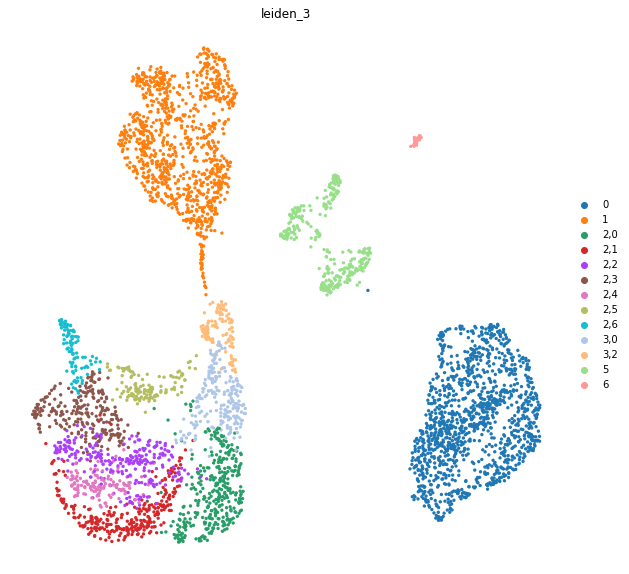

In [49]:
# Plot the UMAP
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata,
    color=["leiden_3"],
    frameon=False,
    size=45,
    ax=ax
)

# Show the plot
plt.show()

In [50]:
# Filter out cluster 2,6 (not showing enterocyte expression, published annotations are in aggreance)
adata = adata[~adata.obs.leiden_3.isin(['2,6'])].copy()

In [51]:
# Combine Enterocyte clusters into one cluster:

# Define the clusters to combine and the target label
clusters_to_combine = [
    '2,0',
    '2,1',
    '2,2',
    '2,3',
    '2,4',
    '2,5'
    ]
target_label = '2'

# Extract the current cluster labels
cluster_labels = adata.obs['leiden_3']

# Update cluster labels for the specified clusters
adata.obs['leiden_3'] = cluster_labels.apply(lambda x: target_label if x in clusters_to_combine else x)

In [54]:
# Combine EEC clusters into one cluster:

# Define the clusters to combine and the target label
clusters_to_combine = [
    '5',
    '6'
    ]
target_label = '5'

# Extract the current cluster labels
cluster_labels = adata.obs['leiden_3']

# Update cluster labels for the specified clusters
adata.obs['leiden_3'] = cluster_labels.apply(lambda x: target_label if x in clusters_to_combine else x)

## Name the clusters to represent their respective cell type

In [56]:
# Annotate the newly clustered EEC clusters based off the marker gene heatmap

map1 = {'Tuft cell': ['0'],
        'Goblet cell': ['1'],
        'Enterocyte': ['2'],
        'Enterocyte progenitor': ['3,0'],
        'ISC': ['3,2'],
        'EEC': ['5']}

class_map = {v: k for k,vv in map1.items() for v in vv}

adata.obs['major_cell_types'] = adata.obs['leiden_3']

adata.obs['major_cell_types'] = adata.obs['leiden_3'].map(class_map)

## Compare published annotations to mine

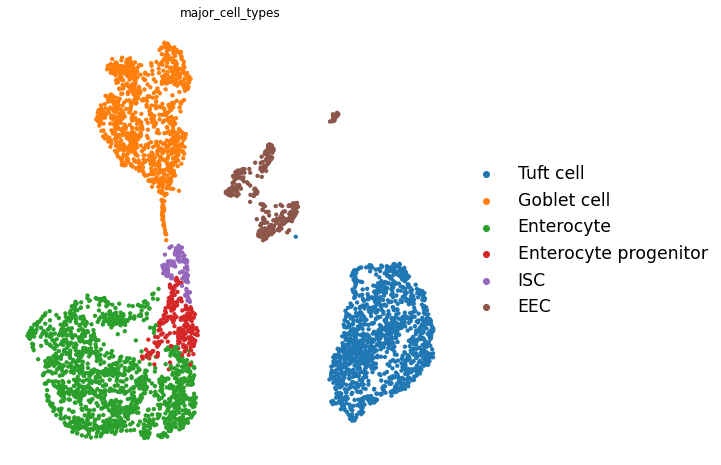

In [17]:
# Plot the UMAP
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata,
    color=["major_cell_types"],
    frameon=False,
    size=75,
    legend_fontsize = 'xx-large',
    ax=ax
)

# Show the plot
plt.show()

In [12]:
## Map the colours from my annotations to the published ones so they're comparable
# Extract the colors from the adata object for major_cell_types
major_cell_types_colors = adata.uns['major_cell_types_colors']

# Create a color map dictionary for major_cell_types
major_cell_types = adata.obs['major_cell_types'].cat.categories
color_map_major = dict(zip(major_cell_types, major_cell_types_colors))

# Manually add the color for 'GP'
color_map_major['GP'] = '#E377C2'  # Example color for Goblet progenitor (GP)

# Define the mapping for published_annotations using the major_cell_types colors and adding GP
published_annotations_mapping = {
    'ISC': color_map_major['ISC'],
    'EP': color_map_major['Enterocyte progenitor'],
    'enterocyte': color_map_major['Enterocyte'],
    'GP': color_map_major['GP'],  # Assign the manually defined color
    'goblet': color_map_major['Goblet cell'],
    'EEC': color_map_major['EEC'],
    'Tuft': color_map_major['Tuft cell'],
    '?': '#FFF9F8',  # Example color for category '?'
    'NA': '#d9d9d9'  # Example color for NA or unannotated
}

# Update the colors in the adata object for published_annotations
adata.uns['published_annotations_colors'] = [published_annotations_mapping[ann] for ann in adata.obs['published_annotations'].cat.categories]


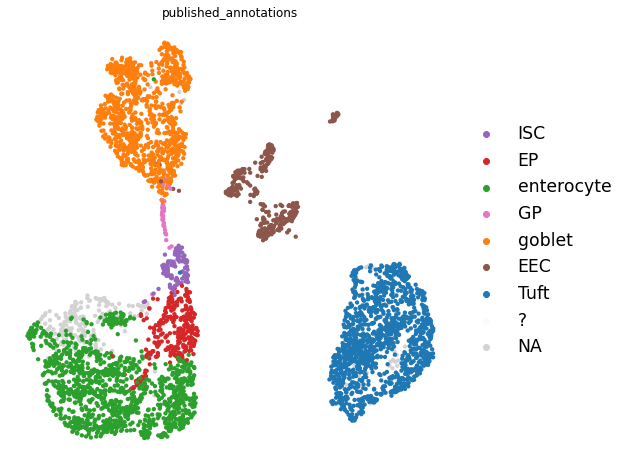

In [18]:
# Plot the UMAP
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata,
    color=["published_annotations"],
    frameon=False,
    size=75,
    legend_fontsize = 'xx-large',
    ax=ax
)

# Show the plot
plt.show()

## View clusters based on diet

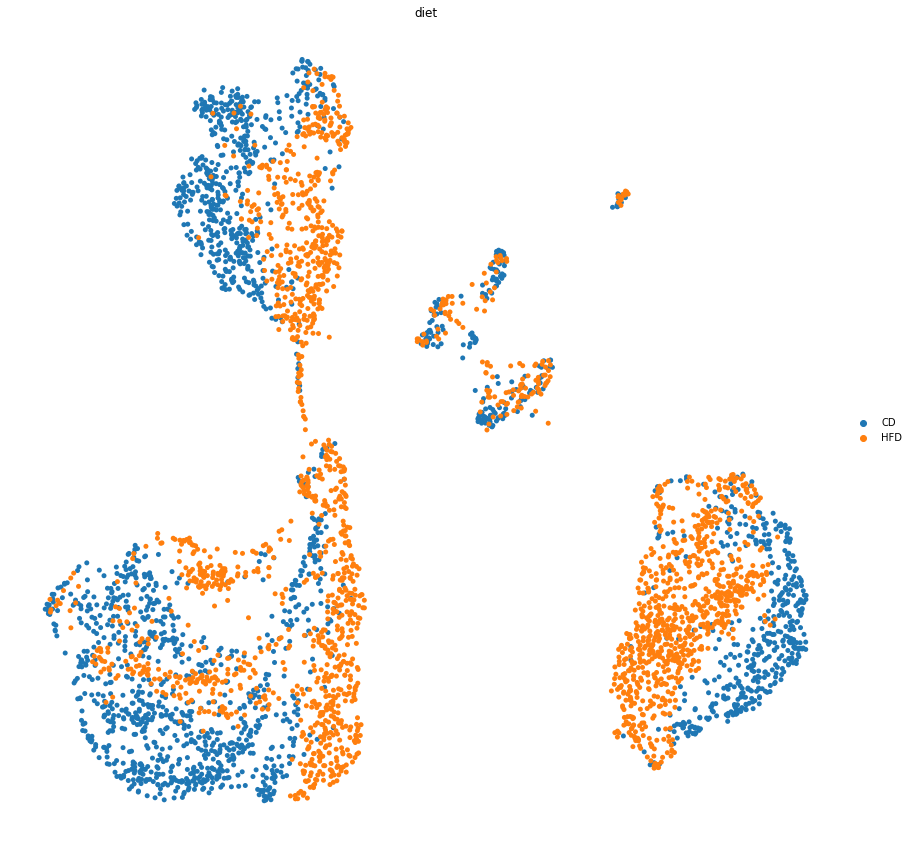

In [21]:
# Plot the UMAP
fig, ax = plt.subplots(figsize=(15, 15))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata,
    color=["diet"],
    frameon=False,
    size=100,
    ax=ax
)

# Show the plot
plt.show()

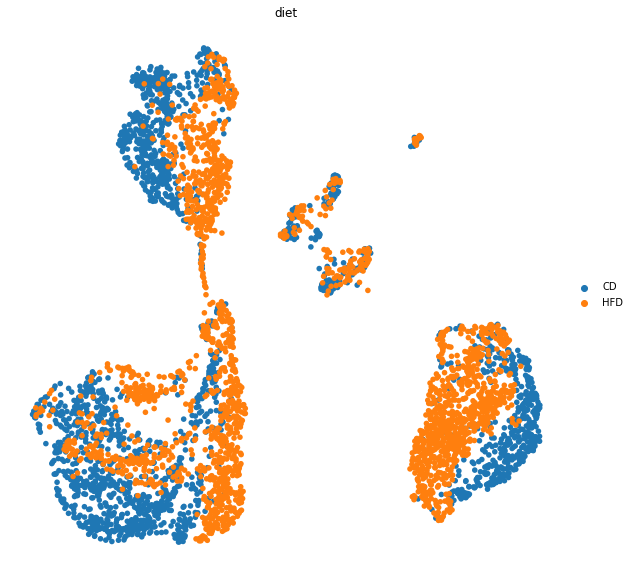

In [67]:
# Plot the UMAP
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata,
    color=["diet"],
    frameon=False,
    size=125,
    ax=ax
)

# Show the plot
plt.show()

## Write to H5ad file

In [68]:
adata.write('villus_enriched.h5ad')

In [3]:
adata = sc.read_h5ad('villus_enriched.h5ad')

## Stacked Barplot of proportions of cell types across diets

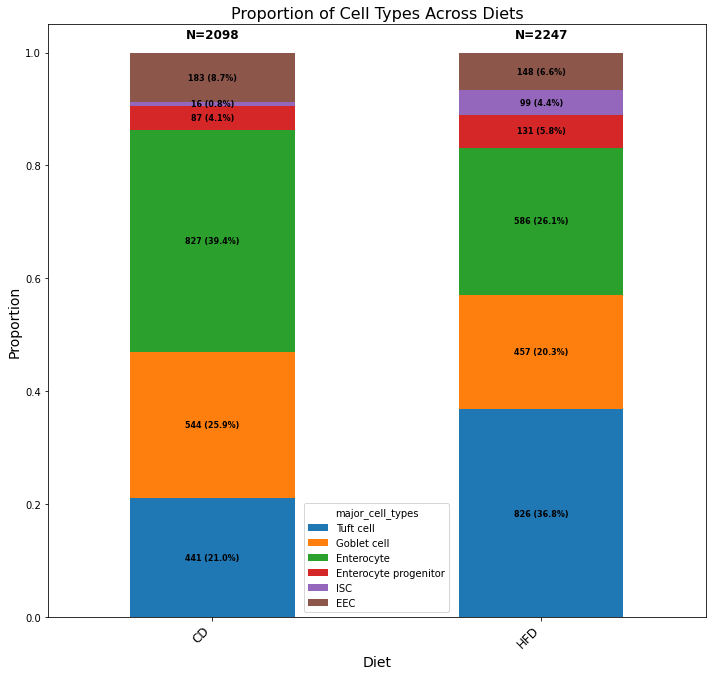

In [5]:
# Calculate the proportions and counts of each cell type within each condition
cell_type_counts = adata.obs.groupby(['diet', 'major_cell_types']).size().unstack(fill_value=0)
cell_type_proportions = cell_type_counts.div(cell_type_counts.sum(axis=1), axis=0)

# Sample size per condition
sample_sizes = cell_type_counts.sum(axis=1)

# Extract the predefined colors from the AnnData object
cell_type_colors = adata.uns['major_cell_types_colors']

# Create a color map dictionary
unique_cell_types = cell_type_counts.columns
color_map = dict(zip(unique_cell_types, cell_type_colors))

# Ensure the colors are applied in the same order as the cell types
cell_type_colors = [color_map[cell_type] for cell_type in unique_cell_types]

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each cell type as a stack with predefined colors
bars = cell_type_proportions.plot(kind='bar', stacked=True, ax=ax, color=cell_type_colors)

# Add labels and title with increased font size
ax.set_ylabel('Proportion', fontsize=14)
ax.set_xlabel('Diet', fontsize=14)
ax.set_title('Proportion of Cell Types Across Diets', fontsize=16)

# Annotate sample sizes above each bar
for i, (cond, size) in enumerate(sample_sizes.items()):
    ax.text(i, 1.02, f'N={size}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Annotate number of cells within each cell type on the bar segments
for i, (cond, row) in enumerate(cell_type_counts.iterrows()):
    cum_sum = 0
    for j, (cell_type, count) in enumerate(row.items()):
        proportion = cell_type_proportions.loc[cond, cell_type]
        if proportion > 0:
            percentage = proportion * 100
            ax.text(i, cum_sum + proportion / 2, f'{count} ({percentage:.1f}%)', ha='center', va='center', fontsize=8, color='black', weight = 'bold')
            cum_sum += proportion

# Rotate x-axis labels for better readability and increase font size
plt.xticks(rotation=45, ha='right', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plot
plt.show()